In [1]:
import numpy as np
import cv2
from skimage.util import random_noise

def create_perfect_shape_image(size):
    img = np.zeros((size, size), dtype=np.uint8)
    cv2.rectangle(img, (10, 10, size-10, size-10), 255, -1)
    return img

def add_noise_and_damage(img):
    noisy_img = random_noise(img, mode='s&p', amount=0.1)
    noisy_img = (noisy_img * 255).astype(np.uint8)
    return noisy_img

# Create dataset
perfect_images = []
damaged_images = []
for _ in range(1000):
    perfect_img = create_perfect_shape_image(128)
    damaged_img = add_noise_and_damage(perfect_img)
    perfect_images.append(perfect_img)
    damaged_images.append(damaged_img)

perfect_images = np.array(perfect_images).reshape(-1, 128, 128, 1)
damaged_images = np.array(damaged_images).reshape(-1, 128, 128, 1)


ModuleNotFoundError: No module named 'cv2'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoding
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoding
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = unet((128, 128, 1))
model.summary()


In [ ]:
model.fit(damaged_images, perfect_images, epochs=50, batch_size=16, validation_split=0.2)


In [ ]:
import matplotlib.pyplot as plt

# Test the model
test_img = add_noise_and_damage(create_perfect_shape_image(128))
test_img = test_img.reshape(1, 128, 128, 1)

# Predict the restored image
restored_img = model.predict(test_img)

# Plot the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Damaged Image')
plt.imshow(test_img.reshape(128, 128), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Restored Image')
plt.imshow(restored_img.reshape(128, 128), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Perfect Image')
plt.imshow(create_perfect_shape_image(128), cmap='gray')
plt.show()


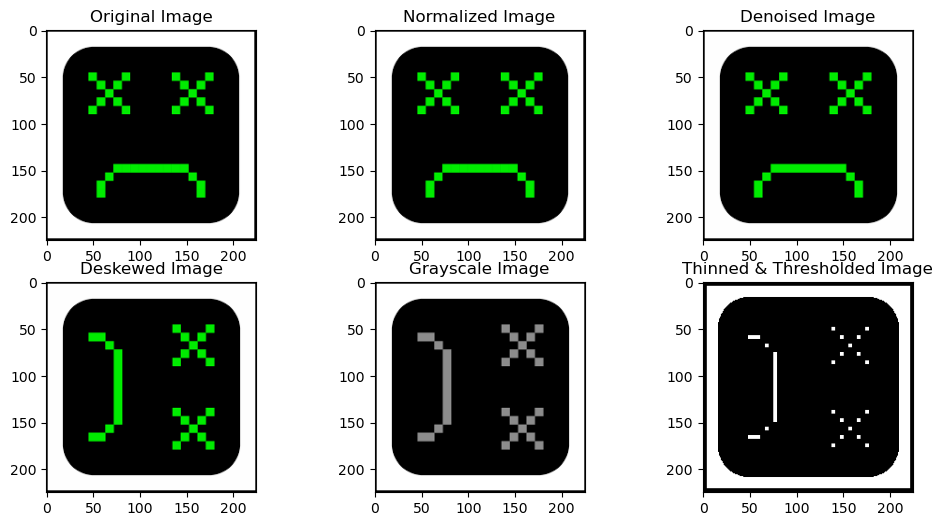

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Normalization
def normalize_image(img):
    norm_img = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
    return img

# 2. Skew Correction
def deskew(image):
    gray = get_grayscale(image)
    co_ords = np.column_stack(np.where(gray > 0))
    angle = cv2.minAreaRect(co_ords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# 3. Noise Removal
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

# 4. Thinning and Skeletonization
def thinning(image):
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(image, kernel, iterations=1)
    return erosion

# 5. Grayscale Image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 6. Thresholding or Binarization
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Load an example image
img_path = '/home/mrinal/Documents/LAN/images.png'
image = cv2.imread(img_path)

# Check if the image was loaded properly
if image is None:
    print("Error: Unable to load image. Please check the image path or URL.")
else:
    # Preprocessing steps
    normalized_img = normalize_image(image)
    denoised_img = remove_noise(normalized_img)
    deskewed_img = deskew(denoised_img)
    gray_img = get_grayscale(deskewed_img)
    thinned_img = thinning(gray_img)
    thresholded_img = thresholding(thinned_img)

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(2, 3, 2)
    plt.title('Normalized Image')
    plt.imshow(cv2.cvtColor(normalized_img, cv2.COLOR_BGR2RGB))

    plt.subplot(2, 3, 3)
    plt.title('Denoised Image')
    plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))

    plt.subplot(2, 3, 4)
    plt.title('Deskewed Image')
    plt.imshow(cv2.cvtColor(deskewed_img, cv2.COLOR_BGR2RGB))

    plt.subplot(2, 3, 5)
    plt.title('Grayscale Image')
    plt.imshow(gray_img, cmap='gray')

    plt.subplot(2, 3, 6)
    plt.title('Thinned & Thresholded Image')
    plt.imshow(thresholded_img, cmap='gray')

    plt.show()


In [3]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 3.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 3.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
